# Collective Quantum Exhaustive Search Experiments
These are defiend by the instructions in an email from 13.2.24 from IA to DM and TM.

### Imports

In [5]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import QuantumCircuit
import networkx as nx
import random
import numpy as np

from hamiltonians import gen_trans_ising_op, get_exact_ground
from mub_state_gen import generate_all_subsets
from landscape import calculate_energy_landscape, find_k_best_results
from graphing import display_energy_landscape, display_energy_histogram
from vqe import Parameters, get_standard_params, run_vqe_experiment

random.seed(7)

## Two-qubit experiments
These experiments are run on two types of examples:
-   Molecular Hamiltonians: H2 and HeH.
-   Transverse-Field Ising Model Hamiltonians.

For these, we will present:
-   The energy landscape sampled using all MUB states (without an appended ansatz).
-   VQE execution from the best 10 MUB states as initial points (awaiting Dekel's code to do this).

### Hamiltonian Generation

In [6]:
H2_ham_0_75 = SparsePauliOp(data= ['II', 'IZ', 'ZI', 'ZZ', 'XX'],
coeffs= [-1.06324002+0.j,  0.38913654+0.j, -0.38913654+0.j, -0.01121274+0.j,  0.18206025+0.j])

HeH_ham_1 = SparsePauliOp(data= ['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'ZX', 'XZ', 'XX'],
coeffs= [-3.04506092+0.j,  0.50258052+0.j,  0.11926278+0.j, -0.50258052+0.j, 0.11926278+0.j, -0.13894646+0.j, -0.11926145+0.j,  0.11926145+0.j,  0.11714671+0.j])

molecular_hams = [("LiH, 0.75A, 2 qubits",H2_ham_0_75), ("HeH, 1A, 2 qubits", HeH_ham_1)]

transverse_hams = [gen_trans_ising_op(2, random.uniform(0,1), random.uniform(0,1)) for _ in range(2)]

### Calculate Landscape

attempting all MUB states over the operator LiH, 0.75A, 2 qubits
Energy Landscape:


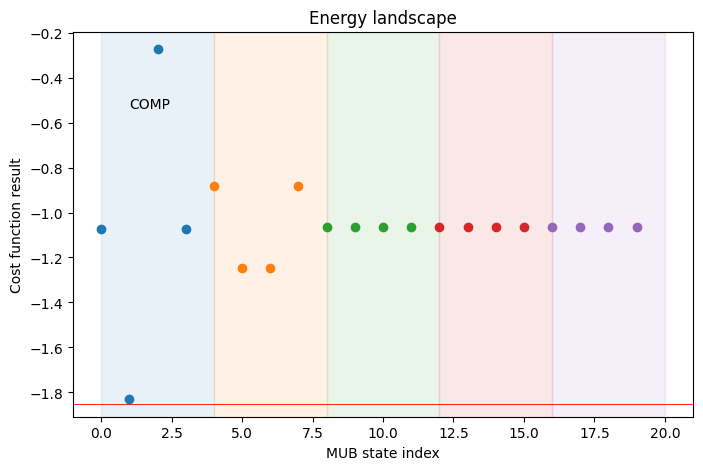

Energy Histogram:


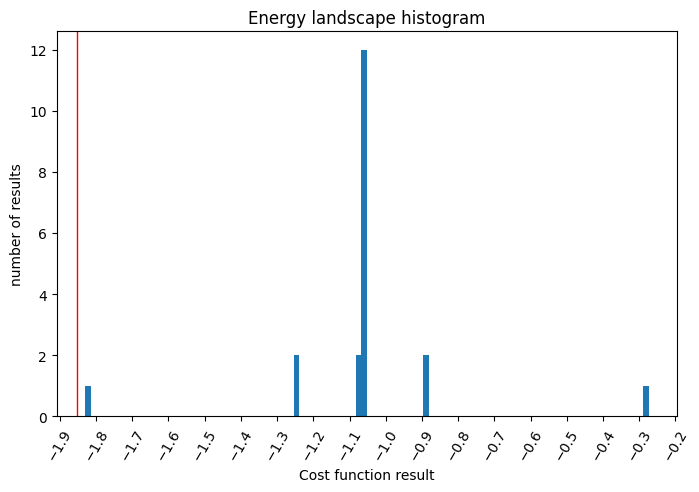

attempting all MUB states over the operator HeH, 1A, 2 qubits
Energy Landscape:


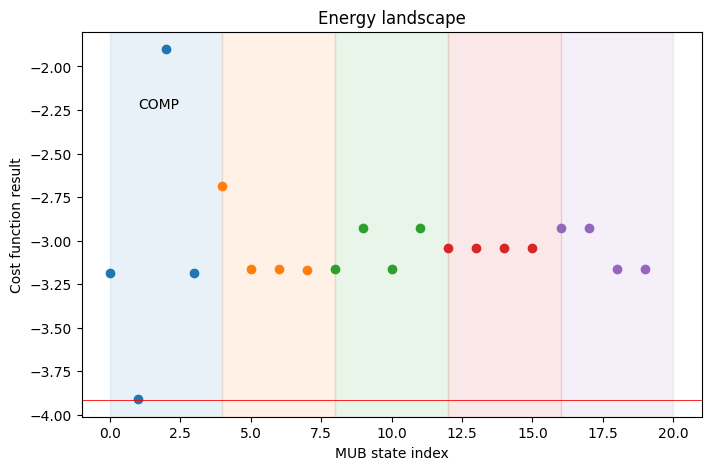

Energy Histogram:


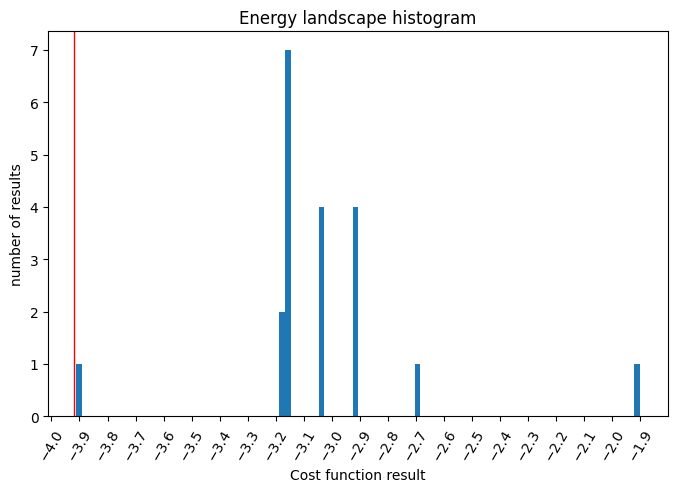

attempting all MUB states over the operator SparsePauliOp(['ZZ', 'XI', 'IX'],
              coeffs=[0.32383276+0.j, 0.15084917+0.j, 0.15084917+0.j])
Energy Landscape:


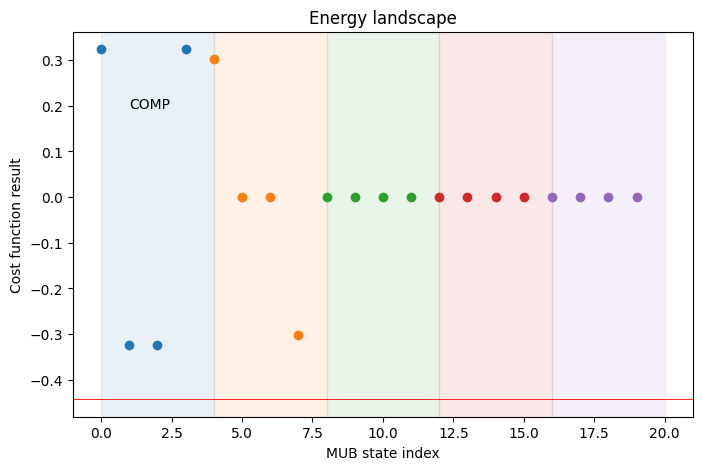

Energy Histogram:


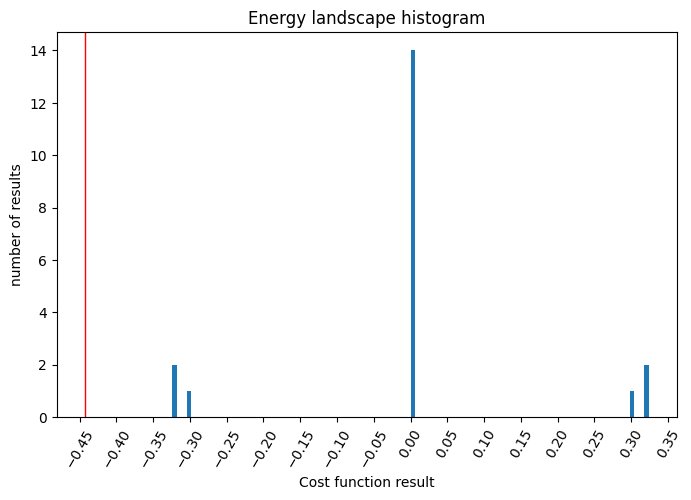

attempting all MUB states over the operator SparsePauliOp(['ZZ', 'XI', 'IX'],
              coeffs=[0.65093447+0.j, 0.07243629+0.j, 0.07243629+0.j])
Energy Landscape:


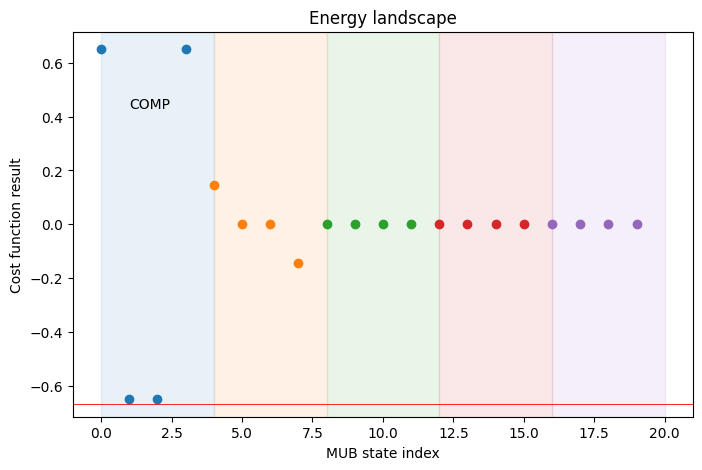

Energy Histogram:


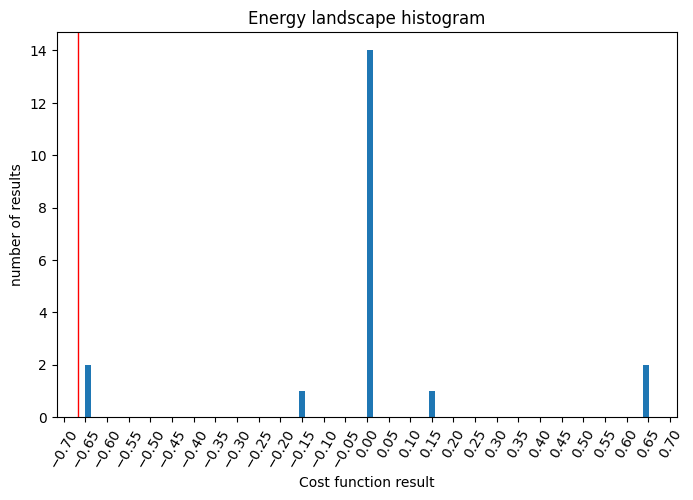

In [7]:
n_qubits = 2
molecular_landscapes = []
transverse_landscapes = []

for op_desc, op in molecular_hams:  # Three examples
    print(f"attempting all MUB states over the operator {op_desc}")
    results = calculate_energy_landscape(op, n_qubits, [(0,1)])
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)
    molecular_landscapes.append((op_desc, op, results))

for op in transverse_hams:  # Three examples
    print(f"attempting all MUB states over the operator {op}")
    results = calculate_energy_landscape(op, n_qubits, [(0,1)])
    exact_result = get_exact_ground(op)
    print("Energy Landscape:")
    display_energy_landscape(results, exact_result=exact_result)
    print("Energy Histogram:")
    display_energy_histogram(results, exact_result=exact_result)
    transverse_landscapes.append((op, results))

### VQE with Dekel's expressive ansatz method

#### The expressive ansatz form

In [2]:
def gen_expressive_ansatz_2qubits(thetas):
    circ = QuantumCircuit(2)
    circ.ry(thetas[0], 0)
    circ.ry(thetas[1], 1)
    circ.rz(thetas[2], 0)
    circ.rz(thetas[3], 1)
    circ.cx(0, 1)
    circ.ry(thetas[4], 0)
    circ.ry(thetas[5], 1)
    circ.rz(thetas[6], 0)
    circ.rz(thetas[7], 1)
    return circ

#### parameters to create MUBS
parameters to 2 qubits MUBs using the CX ansatz format
#### computational basis
[1, 0, 0, 0] - theta = [0, 0, 0, 0, 0, 0, 0, 0]

[0, 1, 0, 0] - theta = [0, 0, 0, 0, $\pi$, 0, 0, 0]

[0, 0, 1, 0] - theta = [0, 0, 0, 0, 0, $\pi$, 0, 0]

[0, 0, 0, 1] - theta = [0, 0, 0, 0, $\pi$, $\pi$, 0, 0]
#### M1
$\frac{1}{2}\cdot$[1, 1, 1, 1] -   theta = [0, 0, 0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, 1, -1, -1] - theta = [0, $-\pi$, 0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, -1, -1, 1] - theta = [$\pi$, 0, 0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, -1, 1, -1] - theta = [$\pi$, $-\pi$, 0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

#### M2
$\frac{1}{2}\cdot$[1, -1, -i, -i] -   theta = [$\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0, 0, 0]

$\frac{1}{2}\cdot$[1, -1, i, i] - theta = [$-\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0, 0, 0]

$\frac{1}{2}\cdot$[1, 1, i, -i] - theta = [$\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0, 0, 0]

$\frac{1}{2}\cdot$[1, 1, -i, i] - theta = [$-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0, 0, 0]

#### M3
$\frac{1}{2}\cdot$[1, -i, -i, -1] -   theta = [0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $ -\frac{\pi}{2}$, $-\frac{\pi}{2}$]

$\frac{1}{2}\cdot$[1, -i, i, 1] - theta = [0, 0, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $ -\frac{\pi}{2}$, $-\frac{\pi}{2}$]

$\frac{1}{2}\cdot$[1, i, i, -1] - theta = [0, 0, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$]

$\frac{1}{2}\cdot$[1, i, -i, 1] - theta = [0, 0, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$]

#### M4
$\frac{1}{2}\cdot$[1, -i, -1, -i] -   theta = [$\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, -i, 1, i] - theta = [$-\frac{\pi}{2}$, $\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, i, -1, i] - theta = [$\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

$\frac{1}{2}\cdot$[1, i, 1, -i] - theta = [$\frac{\pi}{2}$, $-\frac{\pi}{2}$, $-\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, $\frac{\pi}{2}$, 0, 0]

In [4]:
def params_MUB_2q(state_idx, mub_idx):
    # state_idx chooses the state in the basis (MUB)
    # mub_idx chooses the basis (MUB) itself
    if mub_idx == 0:
        if state_idx == 0:
            return [0, 0, 0, 0, 0, 0, 0, 0]
        elif state_idx == 1:
            return [0, 0, 0, 0, np.pi, 0, 0, 0]
        elif state_idx == 2:
            return [0, 0, 0, 0, 0, np.pi, 0, 0]
        elif state_idx == 3:
            return [0, 0, 0, 0, np.pi, np.pi, 0, 0]
    if mub_idx == 1:
        if state_idx == 0:
            return [0, 0, 0, 0, np.pi / 2, np.pi / 2, 0, 0]
        elif state_idx == 1:
            return [0, -np.pi, 0, 0, np.pi / 2, np.pi / 2, 0, 0]
        elif state_idx == 2:
            return [np.pi, 0, 0, 0, np.pi / 2, np.pi / 2, 0, 0]
        elif state_idx == 3:
            return [np.pi, -np.pi, 0, 0, np.pi / 2, np.pi / 2, 0, 0]
    elif mub_idx == 2:
        if state_idx == 0:
            return [np.pi / 2, -np.pi / 2, -np.pi/2, np.pi/2, 0, 0, 0, 0]
        elif state_idx == 1:
            return [-np.pi / 2, np.pi / 2, -np.pi/2, np.pi/2, 0, 0, 0, 0]
        elif state_idx == 2:
            return [np.pi / 2, np.pi / 2, -np.pi/2, np.pi/2, 0, 0, 0, 0]
        elif state_idx == 3:
            return [-np.pi / 2, -np.pi / 2, -np.pi/2, np.pi/2, 0, 0, 0, 0]
    elif mub_idx == 3:
        if state_idx == 0:
            return [0, 0, np.pi/2, np.pi/2, np.pi/2, np.pi/2, -np.pi/2, -np.pi/2]
        elif state_idx == 1:
            return [0, 0, np.pi/2, np.pi/2, np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2]
        elif state_idx == 2:
            return [0, 0, -np.pi/2, -np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2]
        elif state_idx == 3:
            return [0, 0, -np.pi/2, -np.pi/2, np.pi/2, -np.pi/2, np.pi/2, np.pi/2]
    elif mub_idx == 4:
        if state_idx == 0:
            return [np.pi/2, -np.pi/2, np.pi/2, np.pi/2, np.pi/2, np.pi/2, 0, 0]
        elif state_idx == 1:
            return [-np.pi/2, np.pi/2, -np.pi/2, np.pi/2, np.pi/2, np.pi/2, 0, 0]
        elif state_idx == 2:
            return [np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2, np.pi/2, np.pi/2, 0, 0]
        elif state_idx == 3:
            return [np.pi/2, -np.pi/2, -np.pi/2, np.pi/2, np.pi/2, np.pi/2, 0, 0]

## Three-qubit experiments
These experiments are run on two types of examples:
-   Hamiltonian reductions of MAXCUT problem instances.
-   Transverse-Field Ising Model Hamiltonians.

For these, we will present:
-   The energy landscape sampled using all MUB states, with an appended ansatz.
-   VQE execution from the best 10 MUB+ansatz states as initial points.

## >3 qubit experiments
These experiments are run on two types of examples:
-   Hamiltonian reductions of MAXCUT problem instances.
-   Transverse-Field Ising Model Hamiltonians.

For these, we will present:
-   The energy landscape sampled using all partial-MUB states, with an appended ansatz.
-   VQE execution from the best 10 partial-MUB+ansatz states as initial points.